In [1]:
import os
import numpy as np
import random as rn
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1,
    gpu_options=tf.GPUOptions(
        visible_device_list="1", 
        allow_growth=True,
#         per_process_gpu_memory_fraction=0.5
    )
)

from keras import backend as K

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import itertools

from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from keras.models import load_model
from keras.utils import np_utils

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/feature_selection_positive.csv')

In [3]:
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [4]:
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [5]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [6]:
d = {}

In [7]:
xgb_model = pickle.load(open('../model/xgb_pos_fs.sav', 'rb'))
xgb_result = xgb_model.predict_proba(X_test)
# print(xgb_model.score(X_test, y_test))
d['Xgboost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [8]:
rf_model = pickle.load(open('../model/rf_pos_fs.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
# print(rf_model.score(X_test, y_test))
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

In [9]:
lgb_model = pickle.load(open('../model/lgbm_pos_fs.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
# print(lgb_model.score(X_test, y_test))
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [10]:
keras_model  = load_model('../model/Keras_pos_fs.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [11]:
o = {}

In [12]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [13]:
b = pd.DataFrame()
b = pd.concat([b, pd.DataFrame(o).T])

In [14]:
v = pd.DataFrame()
v = pd.concat([v, pd.DataFrame(d).T], axis=1)

In [15]:
b.sort_values(0, ascending=False)

,0
XGBoost + LightGBM + Keras,85.71
LightGBM+Keras,84.82
Random Forest + LightGBM + Keras,84.82
XGBoost + Random Forest + LightGBM + Keras,84.52
XGBoost + LightGBM,83.63
Random Forest + LightGBM,83.63
XGBoost + Random Forest + LightGBM,83.63
XGBoost + Random Forest + Keras,80.06
XGBoost + Ramdom Forest,79.76
XGBoost + Keras,78.87


In [16]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=16)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

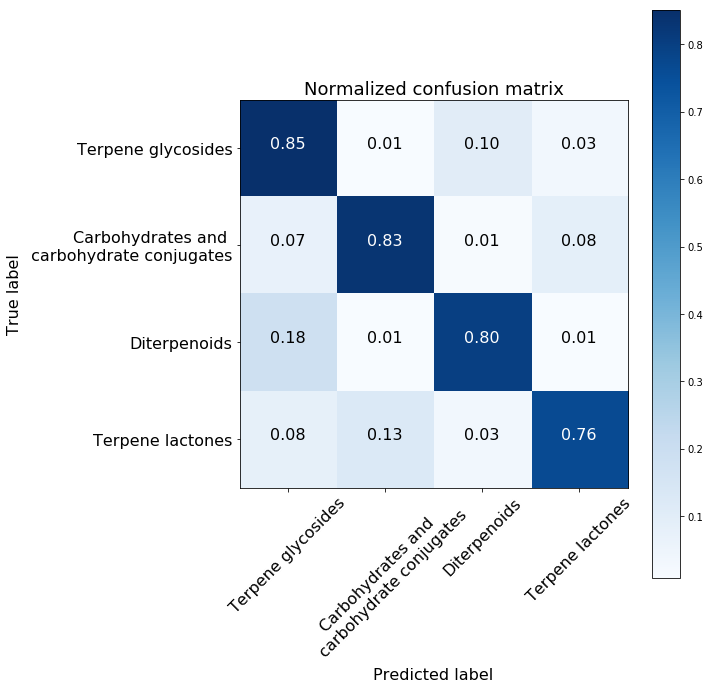

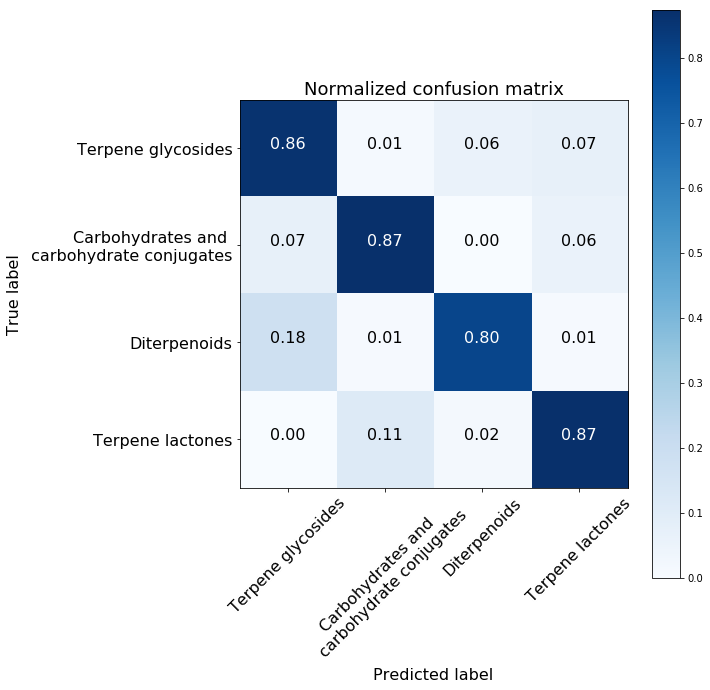

In [17]:
for i in [np.argmax(xgb_result, axis=1), np.argmax(lgb_result , axis=1)]:
    # set name list
    class_names = list(df.Subclass.value_counts().index)
    class_names[1] = 'Carbohydrates and \n carbohydrate conjugates'

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, i)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [18]:
d

{'Xgboost': [81.25],
 'Random Forest': [71.43],
 'LightGBM': [84.52],
 'Keras': [61.61]}

In [19]:
df = pd.read_csv('../data/feature_selection_negative.csv')

In [20]:
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [21]:
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [22]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [23]:
d = {}

In [24]:
xgb_model = pickle.load(open('../model/xgb_ng_fs.sav', 'rb'))
xgb_result = xgb_model.predict_proba(X_test)
print(xgb_model.score(X_test, y_test))
d['Xgboost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

0.7340425531914894


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [25]:
rf_model = pickle.load(open('../model/rf_ng_fs.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
print(rf_model.score(X_test, y_test))
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

0.7021276595744681


In [26]:
lgb_model = pickle.load(open('../model/lgbm_ng_fs.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
print(lgb_model.score(X_test, y_test))
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.723404255319149


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [27]:
keras_model  = load_model('../model/Keras_ng_fs.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [28]:
o = {}

In [29]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [30]:
b = pd.concat([b, pd.DataFrame(o).T], axis=1)
v = pd.concat([v, pd.DataFrame(d).T], axis=1)
b = pd.concat([b, v])
b.columns = ['Feature_Selection_Positive', 'Feature_Selection_Negative']

In [31]:
b.sort_values('Feature_Selection_Positive', ascending=False).to_csv('../result/Feature_Selection_voting.csv')